In [47]:
import pandas as pd
import seaborn as sns
import sys,os
sys.path.append(os.path.abspath(os.path.join("..")))
from config import *
from scipy.stats import mode
import numpy as np
import hdbscan
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc,classification_report
import matplotlib.pyplot as plt
from hdbscan import approximate_predict

In [115]:
df = pd.read_csv(vcf_path+"/GenotypeCounts.csv")
df.drop(columns=['patient_id','IL10RA','RELA','TAGAP','PTAFR','IL23R','SDF2L1'], inplace=True) 
labels = df['label']
X = df.drop(columns=['label'])  # Features (independent variables)
y = df['label']  # Target variable (dependent variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

Training set size: (88, 10), Testing set size: (23, 10)


In [106]:
metrics=['l1','l2','chebyshev', 'euclidean', 'braycurtis', 'hamming', 'russellrao', 'sokalsneath', 'manhattan', 'cityblock', 'rogerstanimoto','canberra']

In [ ]:
for i in metrics:
    print(f"Using metric: {i}")
    # Initialize HDBSCAN with the specified metric
    HDBSCAN_clusters = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1, metric=i, prediction_data=True)
    HDBSCAN_clusters.fit(X_train)
    
    # Assign each cluster to the majority label in the training set
    cluster_to_label = {}
    unique_clusters = np.unique(HDBSCAN_clusters.labels_)
    for cluster in unique_clusters:
        mask = HDBSCAN_clusters.labels_ == cluster
        majority_label = mode(y_train[mask])[0]
        cluster_to_label[cluster] = majority_label

    # Use the approximate_predict function from the hdbscan module
    predicted_clusters, strengths = approximate_predict(HDBSCAN_clusters, X_test)
    
    # Access the label for the sample's cluster
    predicted_labels = np.array([cluster_to_label[sample] for sample in predicted_clusters])
    
    # Compute accuracy
    accuracy = accuracy_score(y_test, predicted_labels)
    print(f"Accuracy: {accuracy * 100:.4f}")
    # Classification Report
    print("\nClassification Report:\n", classification_report(y_test, predicted_labels))
    # Confusion Matrix
    cm = confusion_matrix(y_test, predicted_labels)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for metric: {i}")
    plt.show()
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, predicted_labels)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for metric: {i}')
    plt.legend(loc='lower right')
    plt.show()

/mnt/c/Users/Lenovo/Documents/project/capstone_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/Lenovo/Documents/project/capstone_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


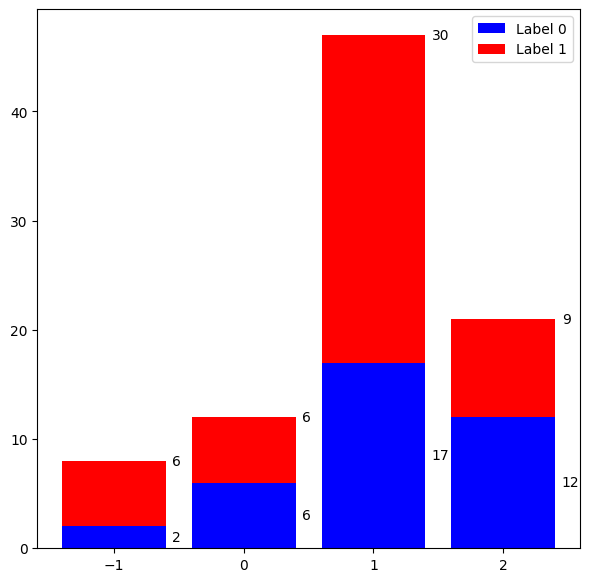

Accuracy: 78.2609

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.79      0.85      0.81        13

    accuracy                           0.78        23
   macro avg       0.78      0.77      0.78        23
weighted avg       0.78      0.78      0.78        23



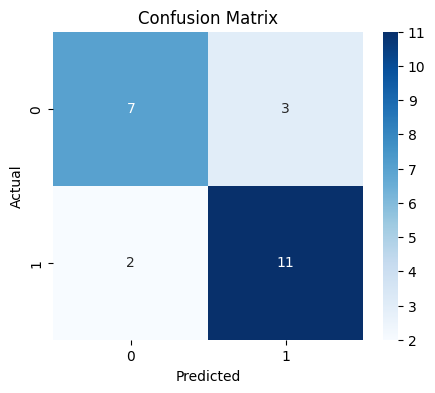

ROC AUC: 0.7731


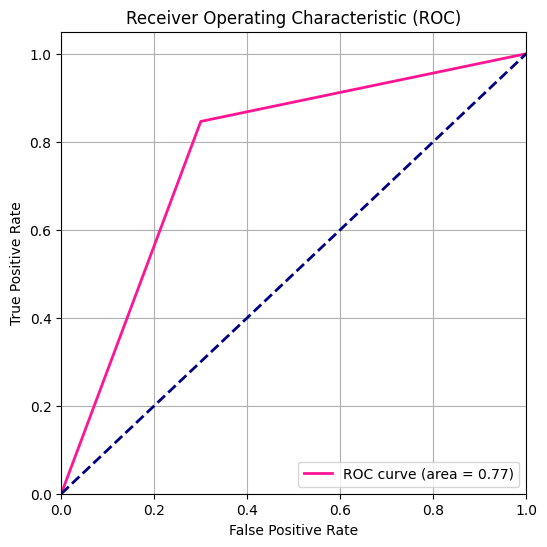

In [116]:
HDBSCAN_clusters = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1, metric='rogerstanimoto', prediction_data=True)
HDBSCAN_clusters.fit(X_train)
# Assign each cluster to the majority label in the training set
cluster_to_label = {}
unique_clusters = np.unique(HDBSCAN_clusters.labels_)
for cluster in unique_clusters:
    mask = HDBSCAN_clusters.labels_ == cluster
    majority_label = mode(y_train[mask])[0]
    cluster_to_label[cluster] = majority_label

cluster_data = pd.DataFrame({'Cluster': HDBSCAN_clusters.labels_, 'Label': y_train})
# Group by both 'Cluster' and 'Label', count occurrences, and reshape using unstack
cluster_counts = cluster_data.groupby(['Cluster', 'Label']).size().unstack(fill_value=0)
# Plot the stacked bar chart
plt.figure(figsize=(7, 7))
# Plot bars for each label in the cluster (assuming two labels: 0 and 1)
bar1 = plt.bar(cluster_counts.index, cluster_counts[0], color='blue', label='Label 0')
bar2 = plt.bar(cluster_counts.index, cluster_counts[1], bottom=cluster_counts[0], color='red', label='Label 1')
# Set the x-axis ticks to match cluster indices
plt.xticks(cluster_counts.index)
# Add legend
plt.legend()
# Annotate bars with values
for bar in bar1:
    yval = bar.get_height()
    # Annotate the bar 0 (Label 0)
    plt.text(bar.get_x() + bar.get_width() + 0.05, yval / 2,  # Place at the center of bar
             int(yval), ha='left', va='center', fontsize=10, color='black')

for bar in bar2:
    yval = bar.get_height()
    # Annotate the bar 1 (Label 1)
    plt.text(bar.get_x() + bar.get_width() + 0.05, yval + bar1[bar2.index(bar)].get_height(), 
             int(yval), ha='left', va='center', fontsize=10, color='black')

# Display the plot
plt.show()
# Use the approximate_predict function from the hdbscan module
predicted_clusters, strengths = approximate_predict(HDBSCAN_clusters, X_test)
# Access the label for the sample's cluster
predicted_labels = np.array([cluster_to_label[sample] for sample in predicted_clusters])
# Compute accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy * 100:.4f}")

# Classification Report

print("\nClassification Report:\n", classification_report(y_test, predicted_labels))

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
fpr, tpr, _ = roc_curve(y_test, predicted_labels)  # If predicted_labels are probabilities, use them directly
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='deeppink', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()